In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error


In [3]:
# ======================================
# ONE-SHOT PIPELINE TO BUILD df_final
# ======================================

import numpy as np
import pandas as pd
import yfinance as yf

# --------------------------------------
# 1. Download Data & Compute Returns
# --------------------------------------
df = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Safe extraction of adjusted close
prices = df['Close']

returns = prices.pct_change().dropna()

# --------------------------------------
# 2. Begin feature table
# --------------------------------------
df_feat = pd.DataFrame()
df_feat["price"] = prices
df_feat["return"] = returns

# --------------------------------------
# 3. Lag Features
# --------------------------------------
df_feat["lag1"] = df_feat["return"].shift(1)
df_feat["lag2"] = df_feat["return"].shift(2)
df_feat["lag5"] = df_feat["return"].shift(5)

# --------------------------------------
# 4. Rolling Means (local trend)
# --------------------------------------
df_feat["roll_mean_5"]  = df_feat["return"].rolling(5).mean()
df_feat["roll_mean_21"] = df_feat["return"].rolling(21).mean()

# --------------------------------------
# 5. Rolling Volatility (risk)
# --------------------------------------
df_feat["roll_vol_5"]  = df_feat["return"].rolling(5).std()
df_feat["roll_vol_21"] = df_feat["return"].rolling(21).std()

# --------------------------------------
# 6. Rolling High/Low (breakout features)
# --------------------------------------
df_feat["roll_max_20"] = df_feat["price"].rolling(20).max()
df_feat["roll_min_20"] = df_feat["price"].rolling(20).min()

# --------------------------------------
# 7. Momentum (multi-period returns)
# --------------------------------------
df_feat["mom_5"]  = df_feat["price"].pct_change(5)
df_feat["mom_21"] = df_feat["price"].pct_change(21)
df_feat["mom_63"] = df_feat["price"].pct_change(63)

# --------------------------------------
# 8. Realized Volatility (RV)
# --------------------------------------
df_feat["rv_21"] = np.sqrt((df_feat["return"]**2).rolling(21).sum() * 252)
df_feat["rv_63"] = np.sqrt((df_feat["return"]**2).rolling(63).sum() * 252)

# --------------------------------------
# 9. Technical Indicators (SMA, EMA)
# --------------------------------------
df_feat["sma_20"] = df_feat["price"].rolling(20).mean()
df_feat["sma_50"] = df_feat["price"].rolling(50).mean()

df_feat["ema_20"] = df_feat["price"].ewm(span=20, adjust=False).mean()
df_feat["ema_50"] = df_feat["price"].ewm(span=50, adjust=False).mean()

# --------------------------------------
# 10. RSI Indicator
# --------------------------------------
delta = df_feat["price"].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)

roll_up = up.rolling(14).mean()
roll_down = down.rolling(14).mean()

rs = roll_up / roll_down
df_feat["rsi_14"] = 100 - (100 / (1 + rs))

# --------------------------------------
# 11. Final cleaning
# --------------------------------------
df_final = df_feat.dropna()

# Show result
df_final.head(), df_final.shape


C:\Users\siddh\AppData\Local\Temp\ipykernel_15024\1537259743.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


(                price    return      lag1      lag2      lag5  roll_mean_5  \
 Date                                                                         
 2015-04-06  28.343861  0.016199  0.008612 -0.001447 -0.007969     0.006665   
 2015-04-07  28.045618 -0.010522  0.016199  0.008612  0.025315    -0.000502   
 2015-04-08  27.954369 -0.003254 -0.010522  0.016199 -0.015352     0.001918   
 2015-04-09  28.168020  0.007643 -0.003254 -0.010522 -0.001447     0.003735   
 2015-04-10  28.288212  0.004267  0.007643 -0.003254  0.008612     0.002867   
 
             roll_mean_21  roll_vol_5  roll_vol_21  roll_max_20  ...     mom_5  \
 Date                                                            ...             
 2015-04-06      0.000449    0.015756     0.014192    28.593134  ...  0.033266   
 2015-04-07     -0.000124    0.013075     0.014388    28.593134  ... -0.002849   
 2015-04-08     -0.000482    0.010507     0.014367    28.593134  ...  0.009403   
 2015-04-09      0.000867    0.0105

In [4]:
# Create next-day return target
df_final["target_next_day"] = df_final["return"].shift(-1)

df_ml = df_final.dropna()


C:\Users\siddh\AppData\Local\Temp\ipykernel_15024\1868429314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["target_next_day"] = df_final["return"].shift(-1)


In [5]:
feature_cols = [
    "lag1","lag2","lag5",
    "roll_mean_5","roll_mean_21",
    "roll_vol_5","roll_vol_21",
    "mom_5","mom_21","mom_63"
]

X = df_ml[feature_cols]
y = df_ml["target_next_day"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [7]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # learn scaling params from train only
X_test_scaled = scaler.transform(X_test)        # apply same scaling to test


In [8]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_pred)
print("Linear Regression Test MSE:", lr_mse)


Linear Regression Test MSE: 0.0003987029999083684


In [9]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
print("Ridge Regression Test MSE:", ridge_mse)


Ridge Regression Test MSE: 0.0003976330674130298


In [10]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)

lasso_mse = mean_squared_error(y_test, lasso_pred)
print("Lasso Regression Test MSE:", lasso_mse)


Lasso Regression Test MSE: 0.0003940695085052327


In [11]:
print("Linear:", lr_mse)
print("Ridge :", ridge_mse)
print("Lasso :", lasso_mse)


Linear: 0.0003987029999083684
Ridge : 0.0003976330674130298
Lasso : 0.0003940695085052327


In [12]:
kf = KFold(n_splits=5, shuffle=False)

ridge_cv = cross_val_score(ridge, X, y, cv=kf, scoring='neg_mean_squared_error')
lasso_cv = cross_val_score(lasso, X, y, cv=kf, scoring='neg_mean_squared_error')

print("Ridge CV MSE:", -ridge_cv.mean())
print("Lasso CV MSE:", -lasso_cv.mean())


Ridge CV MSE: 0.0003583709822622372
Lasso CV MSE: 0.0003580316100456701


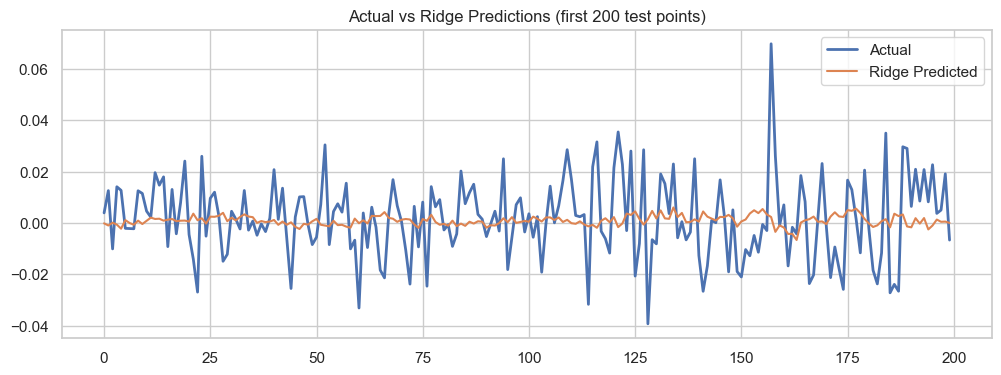

In [13]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(ridge_pred[:200], label="Ridge Predicted")
plt.title("Actual vs Ridge Predictions (first 200 test points)")
plt.legend()
plt.show()


In [15]:
a = [0.01, 0.1, 1, 10, 100]
ridge = Ridge(alpha= 0.01)
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
print("Ridge Regression Test MSE:", ridge_mse)

ridge1 = Ridge(alpha=0.1)
ridge1.fit(X_train_scaled, y_train)

ridge1_pred = ridge1.predict(X_test_scaled)

ridge1_mse = mean_squared_error(y_test, ridge1_pred)
print("Ridge Regression Test MSE:", ridge1_mse)

Ridge Regression Test MSE: 0.0003986599922218287
Ridge Regression Test MSE: 0.00039834385900446


In [16]:
ridge_cv = cross_val_score(ridge, X, y, cv=kf, scoring='neg_mean_squared_error')
ridge1_cv = cross_val_score(ridge1, X, y, cv=kf, scoring='neg_mean_squared_error')

In [20]:
ridge_cv.mean()

np.float64(-0.0003644486060049057)

In [21]:
ridge1_cv.mean()

np.float64(-0.00036129618877087306)

In [22]:
pd.Series(lasso.coef_, index=feature_cols)


lag1            0.000000
lag2           -0.000000
lag5           -0.000041
roll_mean_5    -0.000000
roll_mean_21    0.000000
roll_vol_5     -0.000000
roll_vol_21     0.000000
mom_5          -0.000000
mom_21          0.000000
mom_63         -0.000000
dtype: float64

In [23]:
ensemble_pred = 0.5 * ridge_pred + 0.5 * lasso_pred
mse = mean_squared_error(ensemble_pred)

TypeError: missing a required argument: 'y_pred'